<a href="https://colab.research.google.com/github/ChintPatel/CMPE-258-HW4/blob/main/TensorFlow_2_0_%2B_Keras_Crash_Course.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.18.0


# Part 1: TensorFlow basics

## Tensors

This is a [constant](https://www.tensorflow.org/api_docs/python/tf/constant) tensor:

In [ ]:
x = tf.constant([[5, 2], [1, 3]])
print(x)

tf.Tensor(
[[5 2]
 [1 3]], shape=(2, 2), dtype=int32)


You can get its value as a Numpy array by calling `.numpy()`:

In [ ]:
x.numpy()

array([[5, 2],
       [1, 3]], dtype=int32)

Much like a Numpy array, it features the attributes `dtype` and `shape`:

In [ ]:
print('dtype:', x.dtype)
print('shape:', x.shape)

dtype: <dtype: 'int32'>
shape: (2, 2)


A common way to create constant tensors is via `tf.ones` and `tf.zeros` (just like `np.ones` and `np.zeros`):

In [ ]:
print(tf.ones(shape=(2, 1)))
print(tf.zeros(shape=(2, 1)))

tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[0.]
 [0.]], shape=(2, 1), dtype=float32)


## Random constant tensors

This is all pretty [normal](https://www.tensorflow.org/api_docs/python/tf/random/normal):

In [ ]:
tf.random.normal(shape=(2, 2), mean=0., stddev=1.)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 0.49006018,  1.3902643 ],
       [-1.058516  , -0.85364664]], dtype=float32)>

And here's an integer tensor with values drawn from a random [uniform](https://www.tensorflow.org/api_docs/python/tf/random/uniform) distribution:

In [ ]:
tf.random.uniform(shape=(2, 2), minval=0, maxval=10, dtype='int32')

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[8, 4],
       [8, 7]], dtype=int32)>

## Variables

In [ ]:
initial_value = tf.random.normal(shape=(2, 2))
a = tf.Variable(initial_value)
print(a)

<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[ 1.5680552,  1.7808344],
       [ 1.0862759, -1.1621184]], dtype=float32)>


You update the value of a Variable by using the methods `.assign(value)`, or `.assign_add(increment)` or `.assign_sub(decrement)`:

In [ ]:
new_value = tf.random.normal(shape=(2, 2))
a.assign(new_value)
for i in range(2):
  for j in range(2):
    assert a[i, j] == new_value[i, j]

In [ ]:
added_value = tf.random.normal(shape=(2, 2))
a.assign_add(added_value)
for i in range(2):
  for j in range(2):
    assert a[i, j] == new_value[i, j] + added_value[i, j]

## Doing math in TensorFlow

You can use TensorFlow exactly like you would use Numpy. The main difference is that your TensorFlow code can run on GPU and TPU.

In [ ]:
a = tf.random.normal(shape=(2, 2))
b = tf.random.normal(shape=(2, 2))

c = a + b
d = tf.square(c)
e = tf.exp(d)

## Computing gradients with `GradientTape`

In [ ]:
a = tf.random.normal(shape=(2, 2))
b = tf.random.normal(shape=(2, 2))

with tf.GradientTape() as tape:
  tape.watch(a)  # Start recording the history of operations applied to `a`
  c = tf.sqrt(tf.square(a) + tf.square(b))  # Do some math using `a`
  # What's the gradient of `c` with respect to `a`?
  dc_da = tape.gradient(c, a)
  print(dc_da)

tf.Tensor(
[[-0.727466   -0.8078588 ]
 [-0.85189885  0.56369936]], shape=(2, 2), dtype=float32)


By default, variables are watched automatically, so you don't need to manually `watch` them:

In [ ]:
a = tf.Variable(a)

with tf.GradientTape() as tape:
  c = tf.sqrt(tf.square(a) + tf.square(b))
  dc_da = tape.gradient(c, a)
  print(dc_da)

tf.Tensor(
[[-0.727466   -0.8078588 ]
 [-0.85189885  0.56369936]], shape=(2, 2), dtype=float32)


Note that you can compute higher-order derivatives by nesting tapes:

In [ ]:
with tf.GradientTape() as outer_tape:
  with tf.GradientTape() as tape:
    c = tf.sqrt(tf.square(a) + tf.square(b))
    dc_da = tape.gradient(c, a)
  d2c_da2 = outer_tape.gradient(dc_da, a)
  print(d2c_da2)

tf.Tensor(
[[0.28613707 0.36144072]
 [0.21658128 0.6302936 ]], shape=(2, 2), dtype=float32)


## An end-to-end example: linear regression

So far you've learned that TensorFlow is a Numpy-like library that is GPU or TPU accelerated, with automatic differentiation. Time for an end-to-end example: let's implement a linear regression, the FizzBuzz of Machine Learning.

For the sake of demonstration, we won't use any of the higher-level Keras components like `Layer` or `MeanSquaredError`. Just basic ops.

In [ ]:
input_dim = 2
output_dim = 1
learning_rate = 0.01

# This is our weight matrix
w = tf.Variable(tf.random.uniform(shape=(input_dim, output_dim)))
# This is our bias vector
b = tf.Variable(tf.zeros(shape=(output_dim,)))

def compute_predictions(features):
  return tf.matmul(features, w) + b

def compute_loss(labels, predictions):
  return tf.reduce_mean(tf.square(labels - predictions))

def train_on_batch(x, y):
  with tf.GradientTape() as tape:
    predictions = compute_predictions(x)
    loss = compute_loss(y, predictions)
    # Note that `tape.gradient` works with a list as well (w, b).
    dloss_dw, dloss_db = tape.gradient(loss, [w, b])
  w.assign_sub(learning_rate * dloss_dw)
  b.assign_sub(learning_rate * dloss_db)
  return loss

Let's generate some artificial data to demonstrate our model:

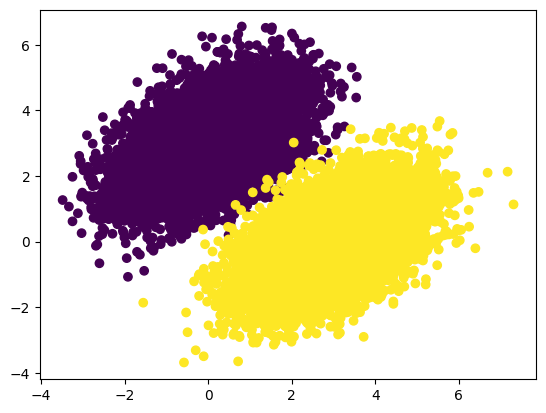

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Prepare a dataset.
num_samples = 10000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3], cov=[[1, 0.5],[0.5, 1]], size=num_samples)
positive_samples = np.random.multivariate_normal(
    mean=[3, 0], cov=[[1, 0.5],[0.5, 1]], size=num_samples)
features = np.vstack((negative_samples, positive_samples)).astype(np.float32)
labels = np.vstack((np.zeros((num_samples, 1), dtype='float32'),
                    np.ones((num_samples, 1), dtype='float32')))

plt.scatter(features[:, 0], features[:, 1], c=labels[:, 0])

Now let's train our linear regression by iterating over batch-by-batch over the data and repeatedly calling `train_on_batch`:

In [ ]:
# Shuffle the data.
indices = np.random.permutation(len(features))
features = features[indices]
labels = labels[indices]

# Create a tf.data.Dataset object for easy batched iteration
dataset = tf.data.Dataset.from_tensor_slices((features, labels))
dataset = dataset.shuffle(buffer_size=1024).batch(256)

for epoch in range(10):
  for step, (x, y) in enumerate(dataset):
    loss = train_on_batch(x, y)
  print('Epoch %d: last batch loss = %.4f' % (epoch, float(loss)))

Epoch 0: last batch loss = 0.0984
Epoch 1: last batch loss = 0.0396
Epoch 2: last batch loss = 0.0344
Epoch 3: last batch loss = 0.0391
Epoch 4: last batch loss = 0.0221
Epoch 5: last batch loss = 0.0292
Epoch 6: last batch loss = 0.0236
Epoch 7: last batch loss = 0.0276
Epoch 8: last batch loss = 0.0234
Epoch 9: last batch loss = 0.0208


Here's how our model performs:

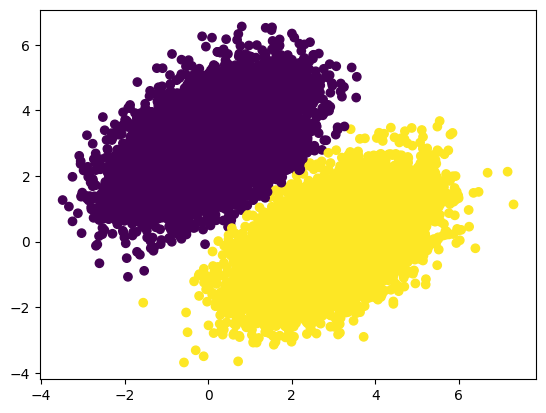

In [ ]:
predictions = compute_predictions(features)
plt.scatter(features[:, 0], features[:, 1], c=predictions[:, 0] > 0.5)

## Making it fast with `tf.function`

But how fast is our current code running?

In [ ]:
import time

t0 = time.time()
for epoch in range(20):
  for step, (x, y) in enumerate(dataset):
    loss = train_on_batch(x, y)
t_end = time.time() - t0
print('Time per epoch: %.3f s' % (t_end / 20,))


Time per epoch: 0.522 s


Let's compile the training function into a static graph. Literally all we need to do is add the `tf.function` decorator on it:

In [ ]:
@tf.function
def train_on_batch(x, y):
  with tf.GradientTape() as tape:
    predictions = compute_predictions(x)
    loss = compute_loss(y, predictions)
    dloss_dw, dloss_db = tape.gradient(loss, [w, b])
  w.assign_sub(learning_rate * dloss_dw)
  b.assign_sub(learning_rate * dloss_db)
  return loss

Let's try this again:

In [ ]:
t0 = time.time()
for epoch in range(20):
  for step, (x, y) in enumerate(dataset):
    loss = train_on_batch(x, y)
t_end = time.time() - t0
print('Time per epoch: %.3f s' % (t_end / 20,))

Time per epoch: 0.120 s


40% reduction, neat. In this case we used a trivially simple model; in general the bigger the model the greater the speedup you can get by leveraging static graphs.

Remember: eager execution is great for debugging and printing results line-by-line, but when it's time to scale, static graphs are a researcher's best friends.

# Part 2: The Keras API

Keras is a Python API for deep learning. It has something for everyone:

- If you're an engineer, Keras provides you with reusable blocks such as layers, metrics, training loops, to support common use cases. It provides a high-level user experience that's accessible and productive.

- If you're a researcher, you may prefer not to use these built-in blocks such as layers and training loops, and instead create your own. Of course, Keras allows you to do this. In this case, Keras provides you with templates for the blocks you write, it provides you with structure, with an API standard for things like Layers and Metrics. This structure makes your code easy to share with others and easy to integrate in production workflows.

- The same is true for library developers: TensorFlow is a large ecosystem. It has many different libraries. In order for different libraries to be able to talk to each other and share components, they need to follow an API standard. That's what Keras provides.

Crucially, Keras brings high-level UX and low-level flexibility together fluently: you no longer have on one hand, a high-level API that's easy to use but inflexible, and on the other hand a low-level API that's flexible but only approachable by experts. Instead, you have a spectrum of workflows, from the  very high-level to the very low-level. Workflows that are all compatible because they're built on top of the same concepts and objects.

![Spectrum of Keras workflows](https://keras-dev.s3.amazonaws.com/tutorials-img/spectrum-of-workflows.png)




## The base `Layer` class

The first class you need to know is [`Layer`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer). Pretty much everything in Keras derives from it.

A Layer encapsulates a state (weights) and some computation (defined in the `call` method).

In [ ]:
from tensorflow.keras.layers import Layer

class Linear(Layer):
  """y = w.x + b"""

  def __init__(self, units=32, input_dim=32):
      super(Linear, self).__init__()
      w_init = tf.random_normal_initializer()
      self.w = tf.Variable(
          initial_value=w_init(shape=(input_dim, units), dtype='float32'),
          trainable=True)
      b_init = tf.zeros_initializer()
      self.b = tf.Variable(
          initial_value=b_init(shape=(units,), dtype='float32'),
          trainable=True)

  def call(self, inputs):
      return tf.matmul(inputs, self.w) + self.b

# Instantiate our layer.
linear_layer = Linear(4, 2)

A layer instance works like a function. Let's call it on some data:

In [ ]:
y = linear_layer(tf.ones((2, 2)))
assert y.shape == (2, 4)

The `Layer` class takes care of tracking the weights assigned to it as attributes:

Note that's also a shortcut method for creating weights: `add_weight`. Instead of doing

```python
w_init = tf.random_normal_initializer()
self.w = tf.Variable(initial_value=w_init(shape=shape, dtype='float32'))
```

You would typically do:

```python
self.w = self.add_weight(shape=shape, initializer='random_normal')
```

It’s good practice to create weights in a separate `build` method, called lazily with the shape of the first inputs seen by your layer. Here, this pattern prevents us from having to specify input_dim in the constructor:

In [ ]:
class Linear(Layer):
  """y = w.x + b"""

  def __init__(self, units=32):
      super(Linear, self).__init__()
      self.units = units

  def build(self, input_shape):
      self.w = self.add_weight(shape=(input_shape[-1], self.units),
                               initializer='random_normal',
                               trainable=True)
      self.b = self.add_weight(shape=(self.units,),
                               initializer='random_normal',
                               trainable=True)

  def call(self, inputs):
      return tf.matmul(inputs, self.w) + self.b


# Instantiate our lazy layer.
linear_layer = Linear(4)

# This will also call `build(input_shape)` and create the weights.
y = linear_layer(tf.ones((2, 2)))
assert len(linear_layer.weights) == 2

## Trainable and non-trainable weights

Weights created by layers can be either trainable or non-trainable. They're exposed in `trainable_weights` and `non_trainable_weights`. Here's a layer with a non-trainable weight:

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class ComputeSum(Layer):
    """Returns the sum of the inputs."""

    def __init__(self, input_dim):
        super(ComputeSum, self).__init__()
        # Properly register the variable as non-trainable using add_weight
        self.total = self.add_weight(
            shape=(input_dim,),
            initializer="zeros",
            trainable=False
        )

    def call(self, inputs):
        self.total.assign_add(tf.reduce_sum(inputs, axis=0))
        return self.total

my_sum = ComputeSum(2)
x = tf.ones((2, 2))

y = my_sum(x)
print(y.numpy())  # [2. 2.]

y = my_sum(x)
print(y.numpy())  # [4. 4.]

# Now, these assertions should pass
assert my_sum.weights == [my_sum.total]
assert my_sum.non_trainable_weights == [my_sum.total]
assert my_sum.trainable_weights == []


[2. 2.]
[4. 4.]


## Recursively composing layers

Layers can be recursively nested to create bigger computation blocks. Each layer will track the weights of its sublayers (both trainable and non-trainable).

In [ ]:
# Let's reuse the Linear class
# with a `build` method that we defined above.

class MLP(Layer):
    """Simple stack of Linear layers."""

    def __init__(self):
        super(MLP, self).__init__()
        self.linear_1 = Linear(32)
        self.linear_2 = Linear(32)
        self.linear_3 = Linear(10)

    def call(self, inputs):
        x = self.linear_1(inputs)
        x = tf.nn.relu(x)
        x = self.linear_2(x)
        x = tf.nn.relu(x)
        return self.linear_3(x)

mlp = MLP()

# The first call to the `mlp` object will create the weights.
y = mlp(tf.ones(shape=(3, 64)))

# Weights are recursively tracked.
assert len(mlp.weights) == 6

In [ ]:
from tensorflow.keras.layers import Layer

class Dropout(Layer):

  def __init__(self, rate):
    super(Dropout, self).__init__()
    self.rate = rate

  def call(self, inputs, training=None):
    if training:
      return tf.nn.dropout(inputs, rate=self.rate)
    return inputs

class MLPWithDropout(Layer):

  def __init__(self):
      super(MLPWithDropout, self).__init__()
      self.linear_1 = Linear(32)
      self.dropout = Dropout(0.5)
      self.linear_3 = Linear(10)

  def call(self, inputs, training=None):
      x = self.linear_1(inputs)
      x = tf.nn.relu(x)
      x = self.dropout(x, training=training)
      return self.linear_3(x)

mlp = MLPWithDropout()
y_train = mlp(tf.ones((2, 2)), training=True)
y_test = mlp(tf.ones((2, 2)), training=False)

## A more Functional way of defining models

To build deep learning models, you don't have to use object-oriented programming all the time. Layers can also be composed functionally, like this (we call it the "Functional API"):

In [ ]:
# We use an `Input` object to describe the shape and dtype of the inputs.
# This is the deep learning equivalent of *declaring a type*.
# The shape argument is per-sample; it does not include the batch size.
# The functional API focused on defining per-sample transformations.
# The model we create will automatically batch the per-sample transformations,
# so that it can be called on batches of data.
inputs = tf.keras.Input(shape=(16,))

# We call layers on these "type" objects
# and they return updated types (new shapes/dtypes).
x = Linear(32)(inputs) # We are reusing the Linear layer we defined earlier.
x = Dropout(0.5)(x) # We are reusing the Dropout layer we defined earlier.
outputs = Linear(10)(x)

# A functional `Model` can be defined by specifying inputs and outputs.
# A model is itself a layer like any other.
model = tf.keras.Model(inputs, outputs)

# A functional model already has weights, before being called on any data.
# That's because we defined its input shape in advance (in `Input`).
assert len(model.weights) == 4

# Let's call our model on some data.
y = model(tf.ones((2, 16)))
assert y.shape == (2, 10)

The Functional API tends to be more concise than subclassing, and provides a few other advantages (generally the same advantages that functional, typed languages provide over untyped OO development). However, it can only be used to define DAGs of layers -- recursive networks should be defined as `Layer` subclasses instead.

Key differences between models defined via subclassing and Functional models are explained in [this blog post](https://medium.com/tensorflow/what-are-symbolic-and-imperative-apis-in-tensorflow-2-0-dfccecb01021).

Learn more about the Functional API [here](https://www.tensorflow.org/alpha/guide/keras/functional).

In your research workflows, you may often find yourself mix-and-matching OO models and Functional models.

For models that are simple stacks of layers with a single input and a single output, you can also use the `Sequential` class which turns a list of layers into a `Model`:

In [ ]:
from tensorflow.keras import Sequential

model = Sequential([Linear(32), Dropout(0.5), Linear(10)])

y = model(tf.ones((2, 16)))
assert y.shape == (2, 10)

## Loss classes

Keras features a wide range of built-in loss classes, like `BinaryCrossentropy`, `CategoricalCrossentropy`, `KLDivergence`, etc. They work like this:

In [ ]:
bce = tf.keras.losses.BinaryCrossentropy()
y_true = [0., 0., 1., 1.]  # Targets
y_pred = [1., 1., 1., 0.]  # Predictions
loss = bce(y_true, y_pred)
print('Loss:', loss.numpy())

Loss: 12.000716


Note that loss classes are stateless: the output of `__call__` is only a function of the input.

## Metric classes

Keras also features a wide range of built-in metric classes, such as `BinaryAccuracy`, `AUC`, `FalsePositives`, etc.

Unlike losses, metrics are stateful. You update their state using the `update_state` method, and you query the scalar metric result using `result`:

In [ ]:
m = tf.keras.metrics.AUC()
m.update_state([0, 1, 1, 1], [0, 1, 0, 0])
print('Intermediate result:', m.result().numpy())

m.update_state([1, 1, 1, 1], [0, 1, 1, 0])
print('Final result:', m.result().numpy())

Intermediate result: 0.6666667
Final result: 0.71428573


The internal state can be cleared with `metric.reset_states`.

You can easily roll out your own metrics by subclassing the `Metric` class:

- Create the state variables in `__init__`
- Update the variables given `y_true` and `y_pred` in `update_state`
- Return the metric result in `result`
- Clear the state in `reset_states`

Here's a quick implementation of a `BinaryTruePositives` metric as a demonstration:

In [ ]:
class BinaryTruePositives(tf.keras.metrics.Metric):

  def __init__(self, name='binary_true_positives', **kwargs):
    super(BinaryTruePositives, self).__init__(name=name, **kwargs)
    self.true_positives = self.add_weight(name='tp', initializer='zeros')

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_true = tf.cast(y_true, tf.bool)
    y_pred = tf.cast(y_pred, tf.bool)

    values = tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, True))
    values = tf.cast(values, self.dtype)
    if sample_weight is not None:
      sample_weight = tf.cast(sample_weight, self.dtype)
      values = tf.multiply(values, sample_weight)
    self.true_positives.assign_add(tf.reduce_sum(values))

  def result(self):
    return self.true_positives

  def reset_states(self):
    self.true_positive.assign(0)

m = BinaryTruePositives()
m.update_state([0, 1, 1, 1], [0, 1, 0, 0])
print('Intermediate result:', m.result().numpy())

m.update_state([1, 1, 1, 1], [0, 1, 1, 0])
print('Final result:', m.result().numpy())

Intermediate result: 1.0
Final result: 3.0


## Optimizer classes & a quick end-to-end training loop

You don't normally have to define by hand how to update your variables during gradient descent, like we did in our initial linear regression example. You would usually use one of the built-in Keras optimizer, like `SGD`, `RMSprop`, or `Adam`.

Here's a simple MNSIT example that brings together loss classes, metric classes, and optimizers.

In [ ]:
from tensorflow.keras import layers

# Prepare a dataset.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train[:].reshape(60000, 784).astype('float32') / 255
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.shuffle(buffer_size=1024).batch(64)

# Instantiate a simple classification model
model = tf.keras.Sequential([
  layers.Dense(256, activation=tf.nn.relu),
  layers.Dense(256, activation=tf.nn.relu),
  layers.Dense(10)
])

# Instantiate a logistic loss function that expects integer targets.
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Instantiate an accuracy metric.
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam()

# Iterate over the batches of the dataset.
for step, (x, y) in enumerate(dataset):
  # Open a GradientTape.
  with tf.GradientTape() as tape:

    # Forward pass.
    logits = model(x)

    # Loss value for this batch.
    loss_value = loss(y, logits)

  # Get gradients of loss wrt the weights.
  gradients = tape.gradient(loss_value, model.trainable_weights)

  # Update the weights of our linear layer.
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))

  # Update the running accuracy.
  accuracy.update_state(y, logits)

  # Logging.
  if step % 100 == 0:
    print('Step:', step)
    print('Loss from last step: %.3f' % loss_value)
    print('Total running accuracy so far: %.3f' % accuracy.result())

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Step: 0
Loss from last step: 2.330
Total running accuracy so far: 0.094
Step: 100
Loss from last step: 0.206
Total running accuracy so far: 0.840
Step: 200
Loss from last step: 0.283
Total running accuracy so far: 0.876
Step: 300
Loss from last step: 0.162
Total running accuracy so far: 0.896
Step: 400
Loss from last step: 0.107
Total running accuracy so far: 0.907
Step: 500
Loss from last step: 0.123
Total running accuracy so far: 0.914
Step: 600
Loss from last step: 0.156
Total running accuracy so far: 0.920
Step: 700
Loss from last step: 0.258
Total running accuracy so far: 0.926
Step: 800
Loss from last step: 0.162
Total running accuracy so far: 0.929
Step: 900
Loss from last step: 0.078
Total running accuracy so far: 0.933


We can reuse our `SparseCategoricalAccuracy` metric instance to implement a testing loop:

In [ ]:
import tensorflow as tf

# Define the accuracy metric with a new variable name
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

# Try using reset_state() instead of reset_states()
if hasattr(test_accuracy, "reset_states"):
    test_accuracy.reset_states()
elif hasattr(test_accuracy, "reset_state"):
    test_accuracy.reset_state()  # Use the older method

# Test dataset processing
for step, (x, y) in enumerate(test_dataset):
    logits = model(x)  # Ensure `model` exists
    test_accuracy.update_state(y, logits)

print('Final test accuracy: %.3f' % test_accuracy.result())


Final test accuracy: 0.089


## The `add_loss` method

Sometimes you need to compute loss values on the fly during a foward pass (especially regularization losses). Keras allows you to compute loss values at any time, and to recursively keep track of them via the `add_loss` method.

Here's an example of a layer that adds a sparsity regularization loss based on the L2 norm of the inputs:

In [ ]:
from tensorflow.keras.layers import Layer

class ActivityRegularization(Layer):
  """Layer that creates an activity sparsity regularization loss."""

  def __init__(self, rate=1e-2):
    super(ActivityRegularization, self).__init__()
    self.rate = rate

  def call(self, inputs):
    # We use `add_loss` to create a regularization loss
    # that depends on the inputs.
    self.add_loss(self.rate * tf.reduce_sum(tf.square(inputs)))
    return inputs

Loss values added via `add_loss` can be retrieved in the `.losses` list property of any `Layer` or `Model`:

In [ ]:
from tensorflow.keras import layers

class SparseMLP(Layer):
  """Stack of Linear layers with a sparsity regularization loss."""

  def __init__(self, output_dim):
      super(SparseMLP, self).__init__()
      self.dense_1 = layers.Dense(32, activation=tf.nn.relu)
      self.regularization = ActivityRegularization(1e-2)
      self.dense_2 = layers.Dense(output_dim)

  def call(self, inputs):
      x = self.dense_1(inputs)
      x = self.regularization(x)
      return self.dense_2(x)


mlp = SparseMLP(1)
y = mlp(tf.ones((10, 10)))

print(mlp.losses)  # List containing one float32 scalar

[<tf.Tensor: shape=(), dtype=float32, numpy=0.785277247428894>]


These losses are cleared by the top-level layer at the start of each forward pass -- they don't accumulate. So `layer.losses` always contain only the losses created during the last forward pass. You would typically use these losses by summing them before computing your gradients when writing a training loop.

In [ ]:
# Losses correspond to the *last* forward pass.
mlp = SparseMLP(1)
mlp(tf.ones((10, 10)))
assert len(mlp.losses) == 1
mlp(tf.ones((10, 10)))
assert len(mlp.losses) == 1  # No accumulation.

# Let's demonstrate how to use these losses in a training loop.

# Prepare a dataset.
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
dataset = tf.data.Dataset.from_tensor_slices(
    (x_train.reshape(60000, 784).astype('float32') / 255, y_train))
dataset = dataset.shuffle(buffer_size=1024).batch(64)

# A new MLP.
mlp = SparseMLP(10)

# Loss and optimizer.
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

for step, (x, y) in enumerate(dataset):
  with tf.GradientTape() as tape:
    # Forward pass.
    logits = mlp(x)

    # External loss value for this batch.
    loss = loss_fn(y, logits)

    # Add the losses created during the forward pass.
    loss += sum(mlp.losses)

    # Get gradients of loss wrt the weights.
    gradients = tape.gradient(loss, mlp.trainable_weights)

  # Update the weights of our linear layer.
  optimizer.apply_gradients(zip(gradients, mlp.trainable_weights))

  # Logging.
  if step % 100 == 0:
    print('Loss at step %d: %.3f' % (step, loss))

Loss at step 0: 5.153
Loss at step 100: 2.283
Loss at step 200: 2.258
Loss at step 300: 2.203
Loss at step 400: 2.138
Loss at step 500: 2.077
Loss at step 600: 1.890
Loss at step 700: 1.894
Loss at step 800: 1.818
Loss at step 900: 1.787


## A detailed end-to-end example: a Variational AutoEncoder (VAE)

If you want to take a break from the basics and look at a slightly more advanced example, check out this [Variational AutoEncoder](https://www.tensorflow.org/guide/keras/custom_layers_and_models#putting_it_all_together_an_end-to-end_example) implementation that demonstrates everything you've learned so far:

- Subclassing `Layer`
- Recursive layer composition
- Loss classes and metric classes
- `add_loss`
- `GradientTape`

## Using built-in training loops

It would be a bit silly if you had to write your own low-level training loops every time for simple use cases. Keras provides you with a built-in training loop on the `Model` class. If you want to use it, either subclass from the `Model` class, or create a `Functional` or `Sequential` model.

To demonstrate it, let's reuse the MNIST setup from above:

In [ ]:
# Prepare a dataset.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.shuffle(buffer_size=1024).batch(64)

# Instantiate a simple classification model
model = tf.keras.Sequential([
  layers.Dense(256, activation=tf.nn.relu),
  layers.Dense(256, activation=tf.nn.relu),
  layers.Dense(10)
])

# Instantiate a logistic loss function that expects integer targets.
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Instantiate an accuracy metric.
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam()

First, call `compile` to configure the optimizer, loss, and metrics to monitor.

In [ ]:
model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

Then we call `fit` on our model to pass it the data:

In [ ]:
model.fit(dataset, epochs=3)

Epoch 1/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.4059 - sparse_categorical_accuracy: 0.8805
Epoch 2/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0988 - sparse_categorical_accuracy: 0.9699
Epoch 3/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0619 - sparse_categorical_accuracy: 0.9806


Done!

**Note:** When you use `fit`, by default execution uses static graphs, so you don't need to add any `tf.function` decorators to your model or your layers.

Now let's test it:

In [ ]:
x_test = x_test[:].reshape(10000, 784).astype('float32') / 255
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(128)

loss, acc = model.evaluate(test_dataset)
print('loss: %.3f - acc: %.3f' % (loss, acc))

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1022 - sparse_categorical_accuracy: 0.9712
loss: 0.086 - acc: 0.975


Note that you can also monitor your loss and metrics on some validation data during `fit`.

Also, you can call `fit` directly on Numpy arrays, so no need for the dataset conversion:

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255

num_val_samples = 10000
x_val = x_train[-num_val_samples:]
y_val = y_train[-num_val_samples:]
x_train = x_train[:-num_val_samples]
y_train = y_train[:-num_val_samples]

# Instantiate a simple classification model
model = tf.keras.Sequential([
  layers.Dense(256, activation=tf.nn.relu),
  layers.Dense(256, activation=tf.nn.relu),
  layers.Dense(10)
])

# Instantiate a logistic loss function that expects integer targets.
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Instantiate an accuracy metric.
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=[accuracy])
model.fit(x_train, y_train,
          validation_data=(x_val, y_val),
          epochs=3,
          batch_size=64)

Epoch 1/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.4298 - sparse_categorical_accuracy: 0.8727 - val_loss: 0.1204 - val_sparse_categorical_accuracy: 0.9630
Epoch 2/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0993 - sparse_categorical_accuracy: 0.9690 - val_loss: 0.0914 - val_sparse_categorical_accuracy: 0.9722
Epoch 3/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0600 - sparse_categorical_accuracy: 0.9817 - val_loss: 0.0856 - val_sparse_categorical_accuracy: 0.9752


## Callbacks

One of the neat features of `fit` (besides built-in support for sample weighting and class weighting) is that you can easily customize what happens during training and evaluation by using [callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/).

A callback is an object that is called at different points during training (e.g. at the end of every batch or at the end of every epoch) and takes actions, such as saving a model, mutating variables on the model, loading a checkpoint, stopping training, etc.

There's a bunch of built-in callback available, like `ModelCheckpoint` to save your models after each epoch during training, or `EarlyStopping`, which interrupts training when your validation metrics start stalling.

And you can easily [write your own callbacks](https://www.tensorflow.org/guide/keras/custom_callback).

In [ ]:
# Instantiate a simple classification model
model = tf.keras.Sequential([
  layers.Dense(256, activation=tf.nn.relu),
  layers.Dense(256, activation=tf.nn.relu),
  layers.Dense(10)
])

# Instantiate a logistic loss function that expects integer targets.
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Instantiate an accuracy metric.
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=[accuracy])

# Instantiate some callbacks
callbacks = [tf.keras.callbacks.EarlyStopping(),
             tf.keras.callbacks.ModelCheckpoint(filepath='my_model.keras',
                                                save_best_only=True)]

model.fit(x_train, y_train,
          validation_data=(x_val, y_val),
          epochs=30,
          batch_size=64,
          callbacks=callbacks)

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.4325 - sparse_categorical_accuracy: 0.8707 - val_loss: 0.1121 - val_sparse_categorical_accuracy: 0.9658
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0953 - sparse_categorical_accuracy: 0.9702 - val_loss: 0.0878 - val_sparse_categorical_accuracy: 0.9731
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0595 - sparse_categorical_accuracy: 0.9818 - val_loss: 0.1049 - val_sparse_categorical_accuracy: 0.9700
